[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/Yquetzal/tnetwork/blob/master/article_encoding.ipynb)

# Reproducing results of the graph encoding article
This notebook allows to reproduce results of the article:
`Data compression to choose a proper dynamic network representation`

In [67]:
#If you have not installed tnetwork yet, you need to install it first, for instance with this line

#!pip install --upgrade tnetwork==1.0

In [4]:
import tnetwork as tn
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We first define a function which, given a dynamic graph and a series of periods of aggregations, returns the encoding length according to the 4 encoding strategies for each dynamic graph produced by the periods of aggregation.

Note that the code of the encoding computation itself is available as part of the tnetwork library, and can be found there: `https://github.com/Yquetzal/tnetwork/blob/master/tnetwork/dyn_graph/encodings.py`

In [5]:
# First, we define the functions we want to use to compute encodings
def score_sn_m(g_sn,g_ig):
    return(tn.code_length_SN_M(g_sn))
def score_sn_e(g_sn,g_ig):
    return(tn.code_length_SN_E(g_sn))
def score_ig(g_sn,g_ig):
    return(tn.code_length_IG(g_ig))
def score_ls(g_sn,g_ig):
    return tn.code_length_LS(g_sn)

functions = [score_ls,score_sn_m,score_ig,score_sn_e]
# We also specify the corresponding names to plot on the figures
names= ["$LS$","$SN_M$","$IG$","$SN_E$"]



In [9]:
def compute_stats(ps,tts):
    """
    :param ps: original graph in snpashot format
    :param tts: list of length of sliding windows to test
    """
    sn1 = []
    sn2 = []
    ls = []
    ig=[]
    updates=[]

    scores = []

    for tt in tts:
        print("====",tt," ====")
        ps_tt=ps.aggregate_sliding_window(tt,weighted=False)
        ps_ig = ps_tt.to_DynGraphIG()
        scores.append([tt]+[f(ps_tt,ps_ig) for f in functions])



    df = pd.DataFrame.from_records(scores,columns=["tts"]+names)
    return df

### Real graphs
First, we compute encoding lenght with a real graph. We choose tts to go from 20s (the actual collection frequency) to a period as long as the whole dataset.

We show here a single example as any other network can be treated the same way. Results for graphs used in the paper are available at the end of this notebook.

In [11]:
h = 3600
d=h*24
tts=[5*d,4*d,2*d,d,h*12,h*6,h*4,h*2,h,60*30,60*15,60*5,60*2,60,20]
SP2012 = compute_stats(tn.graph_socioPatterns2012(format=tn.DynGraphSN),tts)

graph will be loaded as:  <class 'tnetwork.dyn_graph.dyn_graph_sn.DynGraphSN'>
==== 432000  ====
==== 345600  ====
==== 172800  ====
==== 86400  ====
==== 43200  ====
==== 21600  ====
==== 14400  ====
==== 7200  ====
==== 3600  ====
==== 1800  ====
==== 900  ====
==== 300  ====
==== 120  ====
==== 60  ====
==== 20  ====


To improve readability of the plots, we create a function to add vertical lines on human-intepretable periods

In [12]:
def print_lines(long):
    plt.axvline(60,color="grey",zorder=1)
    plt.axvline(3600,color="grey",zorder=1)
    plt.axvline(3600*24,color="grey",zorder=1)
    plt.axvline(3600*24*7,color="grey",zorder=1)
    plt.axvline(3600*24*30,color="grey",zorder=1)
    plt.axvline(3600*24*365,color="grey",zorder=1)



    y0=min(long["value"])*0.9
    plt.text(60,y0,'m',rotation=0)
    plt.text(3600,y0,'h',rotation=0)
    plt.text(3600*24,y0,'d',rotation=0)
    plt.text(3600*24*7,y0,'W',rotation=0)
    plt.text(3600*24*30,y0,'M',rotation=0)
    plt.text(3600*24*365,y0,'Y',rotation=0)

Finally, we plot the result

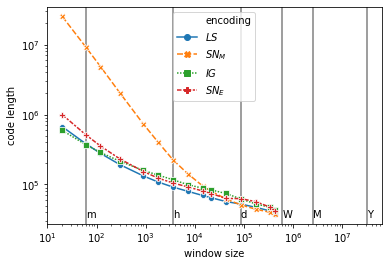

In [47]:
long = pd.melt(SP2012,id_vars=['tts'],value_vars=names)
long["value"]=long["value"]
long["encoding"]=long["variable"]
ax = sns.lineplot(x="tts",y="value",data=long,hue="encoding",markers=True,style="encoding")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("window size")
ax.set_ylabel("code length")
print_lines(long)
plt.savefig('encoding/SP2012.pdf')  

### Synthetic graphs

In [16]:
nb_nodes = 100
nb_edges = 640
nb_steps = 64

#### Stable

In [19]:
tts=[32,16,8,4,2,1]

aGraph = nx.generators.gnm_random_graph(nb_nodes,nb_edges)
dynnet = tn.DynGraphSN([aGraph]*nb_steps)

df_stable = compute_stats(dynnet,tts)

==== 32  ====
==== 16  ====
==== 8  ====
==== 4  ====
==== 2  ====
==== 1  ====


#### Independent snapshots, dense

In [27]:
tts=[32,16,8,4,2,1]

independent = [nx.generators.gnm_random_graph(nb_nodes,nb_edges) for i in range(nb_steps)]
dynnet = tn.DynGraphSN(independent)

df_ind_dense = compute_stats(dynnet,tts)

==== 32  ====
==== 16  ====
==== 8  ====
==== 4  ====
==== 2  ====
==== 1  ====


#### Independent snapshots, sparse

In [29]:
tts=[32,16,8,4,2,1]

independent = [nx.generators.gnm_random_graph(nb_nodes,nb_edges/nb_steps) for i in range(nb_steps)]
dynnet = tn.DynGraphSN(independent)

df_ind_sparse = compute_stats(dynnet,tts)

==== 32  ====
==== 16  ====
==== 8  ====
==== 4  ====
==== 2  ====
==== 1  ====


#### Progressively evolving Graph (PEG) benchmark

In [35]:
tts=[512,256,128,64,32,16,8,4,2,1]
dynnet,_ = tn.generate_simple_random_graph()

df_bench = compute_stats(dynnet.to_DynGraphSN(1),tts)

generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:04 ETA:  00:00:00

==== 512  ====
==== 256  ====
==== 128  ====
==== 64  ====
==== 32  ====
==== 16  ====
==== 8  ====
==== 4  ====
==== 2  ====
==== 1  ====


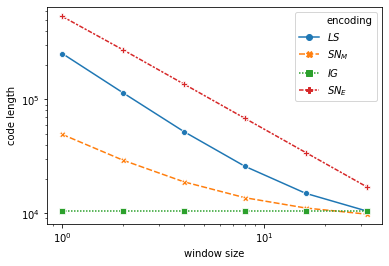

In [42]:
long = pd.melt(df_stable,id_vars=['tts'],value_vars=names)
long["value"]=long["value"]
long["encoding"]=long["variable"]
ax = sns.lineplot(x="tts",y="value",data=long,hue="encoding",markers=True,style="encoding")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("window size")
ax.set_ylabel("code length")
plt.savefig('encoding/stable.pdf')  

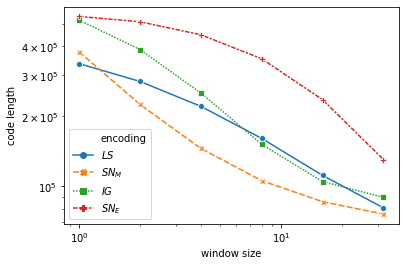

In [43]:
long = pd.melt(df_ind_dense,id_vars=['tts'],value_vars=names)
long["value"]=long["value"]
long["encoding"]=long["variable"]
ax = sns.lineplot(x="tts",y="value",data=long,hue="encoding",markers=True,style="encoding")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("window size")
ax.set_ylabel("code length")
plt.savefig('encoding/independent_dense.pdf')  

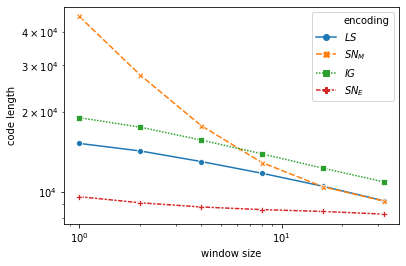

In [44]:
long = pd.melt(df_ind_sparse,id_vars=['tts'],value_vars=names)
long["value"]=long["value"]
long["encoding"]=long["variable"]
ax = sns.lineplot(x="tts",y="value",data=long,hue="encoding",markers=True,style="encoding")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("window size")
ax.set_ylabel("code length")
plt.savefig('encoding/independent_sparse.pdf')  

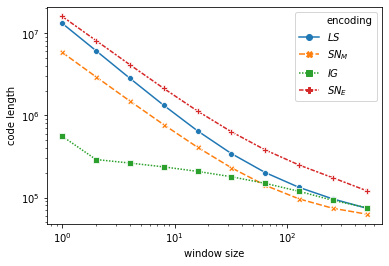

In [45]:
long = pd.melt(df_bench,id_vars=['tts'],value_vars=names)
long["value"]=long["value"]
long["encoding"]=long["variable"]
ax = sns.lineplot(x="tts",y="value",data=long,hue="encoding",markers=True,style="encoding")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("window size")
ax.set_ylabel("code length")
plt.savefig('encoding/bench.pdf')  

## Experiments with other real networks

In [49]:
tts=[2*d,d,h*12,h*6,h*4,h*2,h,60*30,60*15,60*5,60*2,60,20]
SP_hospital = compute_stats(tn.graph_socioPatterns_Hospital(format=tn.DynGraphSN),tts)

graph will be loaded as:  <class 'tnetwork.dyn_graph.dyn_graph_sn.DynGraphSN'>
==== 432000  ====
==== 345600  ====
==== 172800  ====
==== 86400  ====
==== 43200  ====
==== 21600  ====
==== 14400  ====
==== 7200  ====
==== 3600  ====
==== 1800  ====
==== 900  ====
==== 300  ====
==== 120  ====
==== 60  ====
==== 20  ====


In [60]:
tts=[2*d,d,h*12,h*6,h*4,h*2,h,60*30,60*15,60*5,60*2,60,20]
SP_PS = compute_stats(tn.graph_socioPatterns_Primary_School(format=tn.DynGraphSN),tts)

graph will be loaded as:  <class 'tnetwork.dyn_graph.dyn_graph_sn.DynGraphSN'>
==== 172800  ====
==== 86400  ====
==== 43200  ====
==== 21600  ====
==== 14400  ====
==== 7200  ====
==== 3600  ====
==== 1800  ====
==== 900  ====
==== 300  ====
==== 120  ====
==== 60  ====
==== 20  ====


In [61]:
tts=[250,100,50,30,15,10,7,5,4,3,2,1]
GOT = compute_stats(tn.graph_GOT(),tts)

==== 250  ====
==== 100  ====
==== 50  ====
==== 30  ====
==== 15  ====
==== 10  ====
==== 7  ====
==== 5  ====
==== 4  ====
==== 3  ====
==== 2  ====
==== 1  ====


In [55]:
h = 3600
d=h*24
tts=[d*365,d*30,d*7,d,h,60]

location ="ia-enron-employees/"
ENRON = compute_stats(
    tn.read_interactions(location+"ia-enron-employees.edges",format=tn.DynGraphSN,sep=" ",columns=["n1","n2","?","time"])
    ,tts)

graph will be loaded as:  <class 'tnetwork.dyn_graph.dyn_graph_sn.DynGraphSN'>
==== 31536000  ====
==== 2592000  ====
==== 604800  ====
==== 86400  ====
==== 3600  ====
==== 60  ====


In [57]:
location = "mammalia-primate-association/mammalia-primate-association.edges"
largeG = tn.read_interactions(location,sep=" ",columns=["n1","n2","__","time"])
tts=[10,5,2,1]
primate = compute_stats(largeG,tts)

nb_interactions: 1340 nb_unique_Edges: 280 nb_time: 19 nb_nodes: 25
nb intervals:  827
sn_m : 8001.270089029274
ls : 9482.202038052455
ig : 10816.05127727374
sn_e : 12702.711746563129
graph will be loaded as:  <class 'tnetwork.dyn_graph.dyn_graph_sn.DynGraphSN'>
==== 10  ====
==== 5  ====
==== 2  ====
==== 1  ====


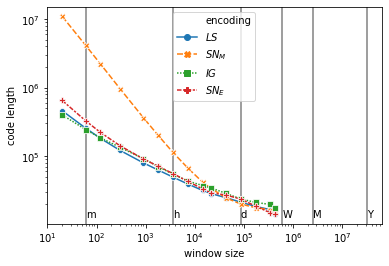

In [58]:
long = pd.melt(SP_hospital,id_vars=['tts'],value_vars=names)
long["value"]=long["value"]
long["encoding"]=long["variable"]
ax = sns.lineplot(x="tts",y="value",data=long,hue="encoding",markers=True,style="encoding")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("window size")
ax.set_ylabel("code length")
print_lines(long)
plt.savefig('encoding/hospital.pdf')  

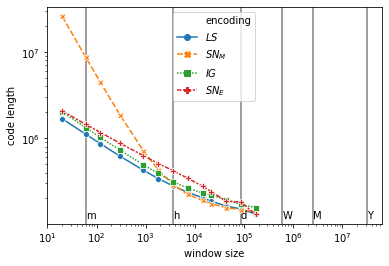

In [63]:
long = pd.melt(SP_PS,id_vars=['tts'],value_vars=names)
long["value"]=long["value"]
long["encoding"]=long["variable"]
ax = sns.lineplot(x="tts",y="value",data=long,hue="encoding",markers=True,style="encoding")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("window size")
ax.set_ylabel("code length")
print_lines(long)
plt.savefig('encoding/PS.pdf')  

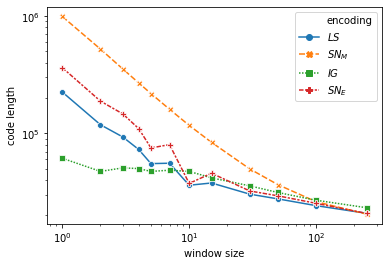

In [64]:
long = pd.melt(GOT,id_vars=['tts'],value_vars=names)
long["value"]=long["value"]
long["encoding"]=long["variable"]
ax = sns.lineplot(x="tts",y="value",data=long,hue="encoding",markers=True,style="encoding")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("window size")
ax.set_ylabel("code length")
plt.savefig('encoding/GOT.pdf')  

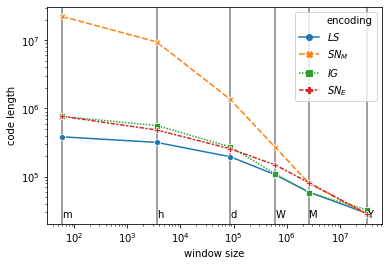

In [65]:
long = pd.melt(ENRON,id_vars=['tts'],value_vars=names)
long["value"]=long["value"]
long["encoding"]=long["variable"]
ax = sns.lineplot(x="tts",y="value",data=long,hue="encoding",markers=True,style="encoding")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("window size")
ax.set_ylabel("code length")
print_lines(long)
plt.savefig('encoding/ENRON.pdf')  

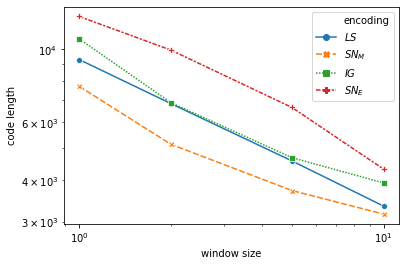

In [66]:
long = pd.melt(primate,id_vars=['tts'],value_vars=names)
long["value"]=long["value"]
long["encoding"]=long["variable"]
ax = sns.lineplot(x="tts",y="value",data=long,hue="encoding",markers=True,style="encoding")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("window size")
ax.set_ylabel("code length")
plt.savefig('encoding/primates.pdf')  